In [1]:
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from bm_functions import collect_correlation_results, collect_metadata


/mnt/f/chrysalis/chrysalis_supplementary_data/I_synthetic_data/tabula_sapiens_immune_contamination/01ebb869cd7d/01ebb869cd7d_sth_adata.h5ad
/mnt/f/chrysalis/chrysalis_supplementary_data/I_synthetic_data/tabula_sapiens_immune_contamination/0917b886d4b9/0917b886d4b9_sth_adata.h5ad
/mnt/f/chrysalis/chrysalis_supplementary_data/I_synthetic_data/tabula_sapiens_immune_contamination/0caa1ed4c2cd/0caa1ed4c2cd_sth_adata.h5ad
/mnt/f/chrysalis/chrysalis_supplementary_data/I_synthetic_data/tabula_sapiens_immune_contamination/0d97ed9c5b65/0d97ed9c5b65_sth_adata.h5ad
/mnt/f/chrysalis/chrysalis_supplementary_data/I_synthetic_data/tabula_sapiens_immune_contamination/0f2b600a249a/0f2b600a249a_sth_adata.h5ad
/mnt/f/chrysalis/chrysalis_supplementary_data/I_synthetic_data/tabula_sapiens_immune_contamination/112b3e51f78c/112b3e51f78c_sth_adata.h5ad
/mnt/f/chrysalis/chrysalis_supplementary_data/I_synthetic_data/tabula_sapiens_immune_contamination/1cd30bcbadc8/1cd30bcbadc8_sth_adata.h5ad
/mnt/f/chrysalis/chr

/tmp/ipykernel_7451/1187111056.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


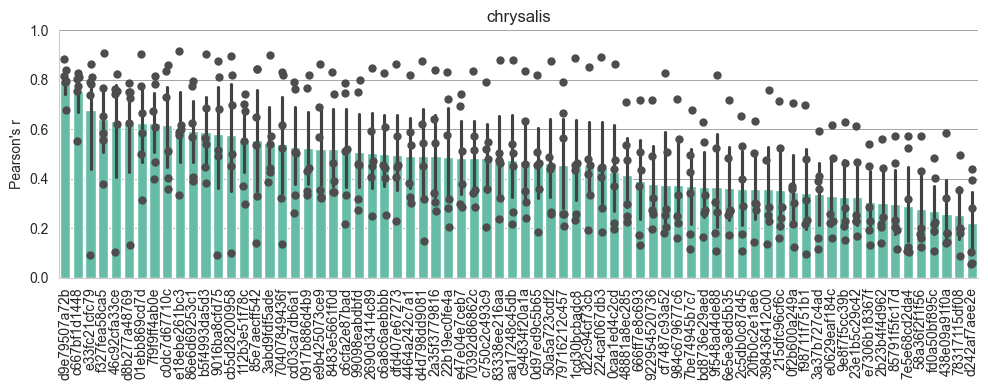

/tmp/ipykernel_7451/1187111056.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


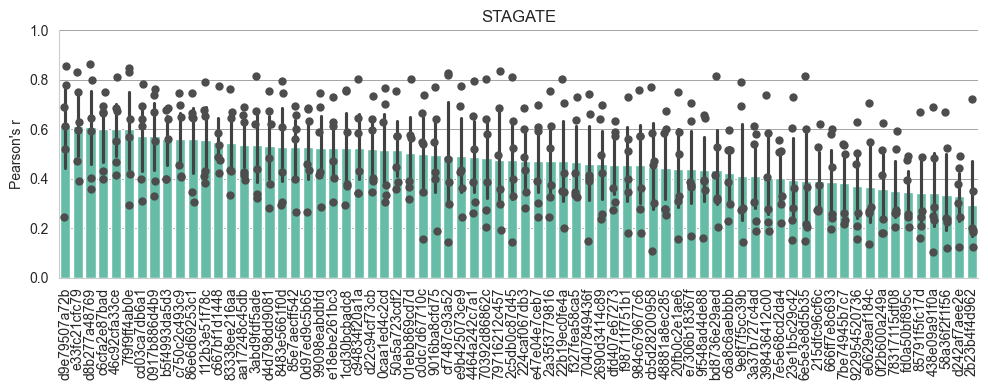

/tmp/ipykernel_7451/1187111056.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


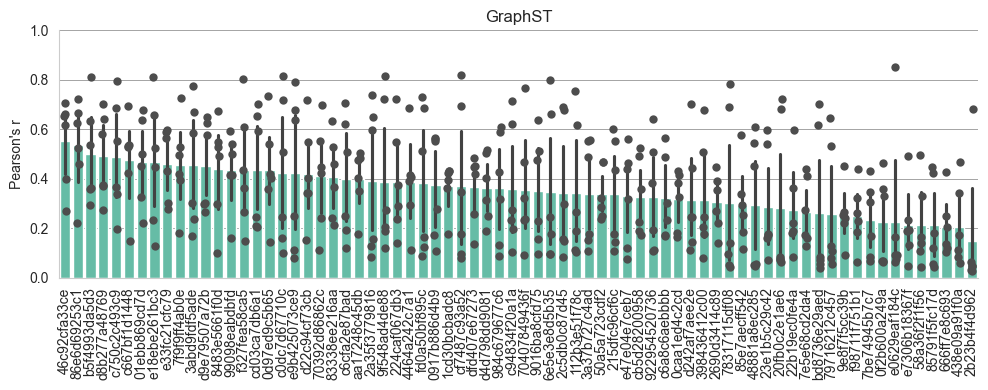

/tmp/ipykernel_7451/1187111056.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


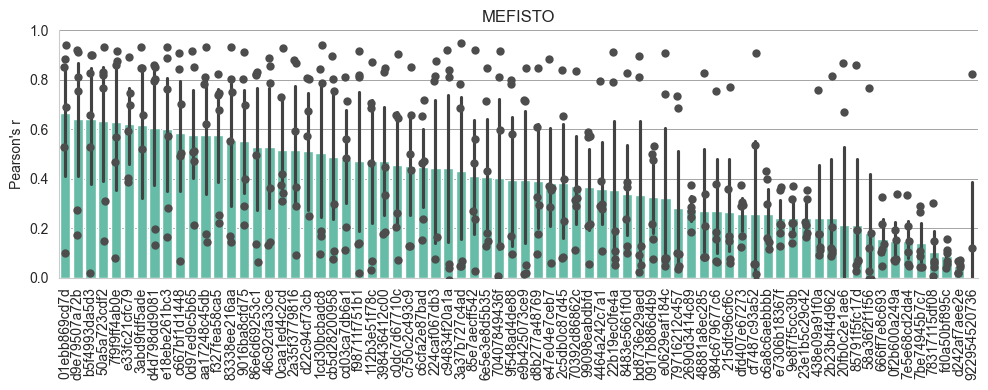

/tmp/ipykernel_7451/1187111056.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


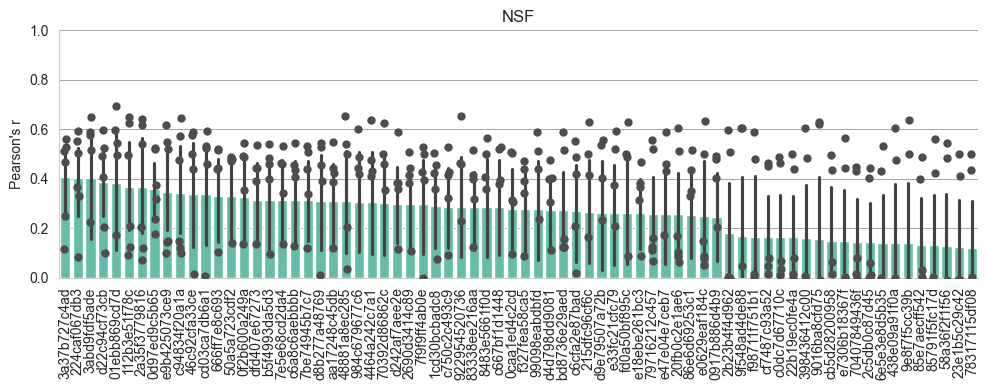

In [2]:
filepath = '/mnt/f/chrysalis/chrysalis_supplementary_data/I_synthetic_data/tabula_sapiens_immune_contamination'
adpaths = glob(filepath + '/*/*.h5ad')

meta_df = collect_metadata(adpaths)

method_suffix = {'chrysalis': 'chrysalis_', 'STAGATE': 'stagate_', 'GraphST': 'graphst_', 'MEFISTO': 'mefisto_', 'NSF': 'nsf_'}
method_df = pd.DataFrame()
method_df_mean = pd.DataFrame()
for name, suffix in method_suffix.items():
    csvs = glob(filepath + f'/*/{suffix}pearson.csv')
    df = collect_correlation_results(csvs)

    df_melted = df.melt(var_name='index', value_name='correlation')
    df_melted = df_melted.merge(meta_df, left_on='index', right_index=True, how='left')
    df_melted = df_melted.dropna()

    # for col in df_melted.columns:
    #     if len(df_melted[col].unique()) == 1:
    #         df_melted.drop(col,inplace=True,axis=1)

    df_melted['method'] = name
    method_df = pd.concat([method_df, df_melted], axis=0, ignore_index=True)

    mean_corr_df = pd.DataFrame(df.mean()).T
    mean_df_melted = mean_corr_df.melt(var_name='hash', value_name='correlation')
    mean_df_melted['index'] = mean_df_melted.index
    mean_df_melted = mean_df_melted.drop(columns=['hash'])
    mean_df_melted = mean_df_melted.merge(meta_df, left_on='index', right_index=True, how='left')

    mean_df_melted['method'] = name
    method_df_mean = pd.concat([method_df_mean, mean_df_melted], axis=0, ignore_index=True)

    df = df.rename(columns={k: v for k, v in zip(meta_df.index, meta_df['hash'])})
    mean_corr = df.mean(axis=0).sort_values(ascending=False)

    # add arial font
    import matplotlib.pyplot as plt
    from matplotlib import font_manager

    font_files = mpl.font_manager.findSystemFonts()
    for font_file in font_files:
        font_manager.fontManager.addfont(font_file)
    # print(font_manager.get_font_names())

    plt.rcParams['svg.fonttype'] = 'none'
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    sns.barplot(df, ax=ax, color='#57CBAD', order=mean_corr.index)
    sns.stripplot(df, ax=ax, size=6, color=".3", order=mean_corr.index)
    ax.grid(axis='y', linestyle='-', linewidth='0.5', color='grey')
    ax.set_axisbelow(True)
    ax.set_ylabel("Pearson's r")
    ax.set_xlabel(None)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_ylim((0, 1))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(name)
    plt.tight_layout()
    plt.show()


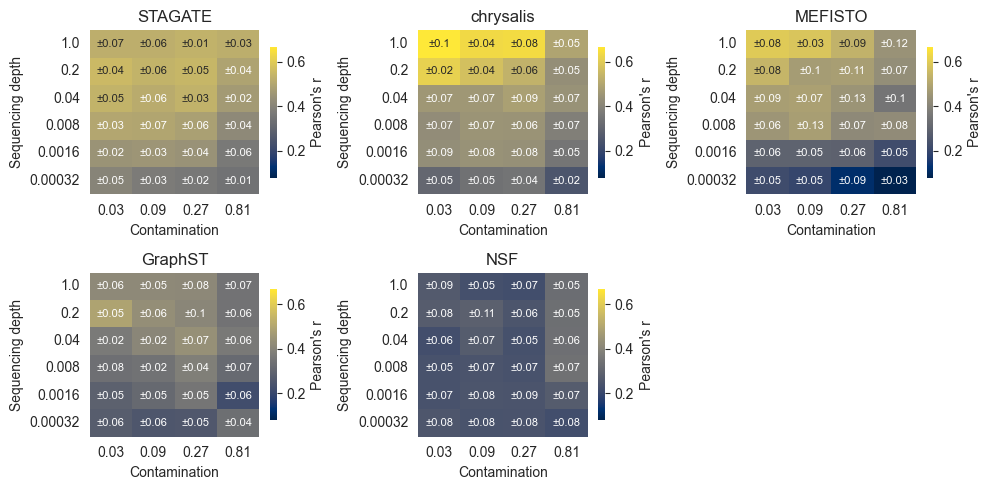

In [3]:
overall_mean = {}
for m in np.unique(method_df_mean['method']):
    v = method_df_mean.loc[method_df_mean['method'] == m, 'correlation'].mean()
    overall_mean[m] = v
overall_mean = pd.Series(overall_mean).sort_values(ascending=False)

from matplotlib import font_manager
font_files = mpl.font_manager.findSystemFonts()
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

vmin = None
vmax = None
for idx, m in enumerate(overall_mean.index):
    mdf_subset = method_df_mean[method_df_mean['method'] == m]
    x_names = np.sort(np.unique(mdf_subset['contamination_override']))
    y_names = np.sort(np.unique(mdf_subset['depth_override']))[::-1]
    method_arr = np.zeros((3, 24))
    for i, s in enumerate(np.unique(mdf_subset['seed'])):
        seed_df = mdf_subset[mdf_subset['seed'] == s]
        result_df = pd.DataFrame(index=y_names, columns=x_names)
        for x in x_names:
            for y in y_names:
                value = seed_df[(seed_df['contamination_override'] == x) &
                                (seed_df['depth_override'] == y)]['correlation']
                if not value.empty:
                    result_df.at[y, x] = value.values[0]
        result_df = result_df.astype(float)
        method_arr[i, :] = result_df.values.flatten()
    mean_vals = np.nanmean(method_arr, axis=0).reshape((6, 4))
    mean_df = pd.DataFrame(data=mean_vals, index=result_df.index, columns=result_df.columns)
    if vmin is None or vmin > np.min(mean_df):
        vmin = np.min(mean_df)
    if vmax is None or vmax < np.max(mean_df):
        vmax = np.max(mean_df)

plt.rcParams['svg.fonttype'] = 'none'
# fig, axs = plt.subplots(1, 5, figsize=(14.0, 2.2))
fig, axs = plt.subplots(2, 3, figsize=(10, 5))
axs = axs.flatten()
for ax in axs:
    ax.axis('off')

for idx, m in enumerate(overall_mean.index):
    mdf_subset = method_df_mean[method_df_mean['method'] == m]

    x_names = np.unique(mdf_subset['contamination_override'])
    y_names = np.sort(np.unique(mdf_subset['depth_override']))[::-1]

    method_arr = np.zeros((3, 24))
    for i, s in enumerate(np.unique(mdf_subset['seed'])):
        seed_df = mdf_subset[mdf_subset['seed'] == s]
        result_df = pd.DataFrame(index=y_names, columns=x_names)
        for x in x_names:
            for y in y_names:
                value = seed_df[(seed_df['contamination_override'] == x) &
                                (seed_df['depth_override'] == y)]['correlation']
                if not value.empty:
                    result_df.at[y, x] = value.values[0]
        result_df = result_df.astype(float)
        method_arr[i, :] = result_df.values.flatten()

    mean_vals = np.nanmean(method_arr, axis=0).reshape((6, 4))
    mean_df = pd.DataFrame(data=mean_vals, index=result_df.index, columns=result_df.columns)

    std_vals = np.std(method_arr, axis=0).reshape((6, 4))
    std_df = pd.DataFrame(data=std_vals, index=result_df.index, columns=result_df.columns)

    # annot_df = mean_df.round(2).astype(str) + "±" + std_df.round(2).astype(str)
    annot_df = "±" + std_df.round(2).astype(str)
    axs[idx].axis('on')
    sns.heatmap(mean_df, square=False, ax=axs[idx], rasterized=True, 
                cbar_kws={'label': "Pearson's r", "shrink": 0.8},
                vmin=vmin, vmax=vmax,
                cmap='cividis',
                annot=annot_df, fmt='', annot_kws={'size': 8},
                )
    axs[idx].set_title(m)
    axs[idx].set_ylabel('Sequencing depth')
    axs[idx].set_xlabel('Contamination')
plt.tight_layout()
plt.show()


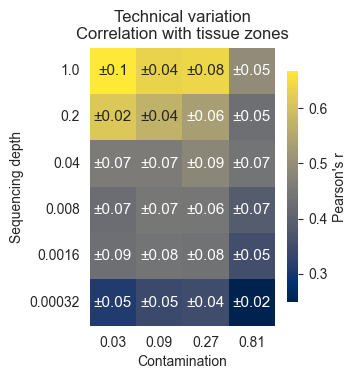

In [4]:
from matplotlib import font_manager

font_files = mpl.font_manager.findSystemFonts()
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
# print(font_manager.get_font_names())

m = 'chrysalis'
fig, ax = plt.subplots(1, 1, figsize=(3.5, 4))

mdf_subset = method_df_mean[method_df_mean['method'] == m]

x_names = np.unique(mdf_subset['contamination_override'])
y_names = np.sort(np.unique(mdf_subset['depth_override']))[::-1]

method_arr = np.zeros((3, 24))
for i, s in enumerate(np.unique(mdf_subset['seed'])):
    seed_df = mdf_subset[mdf_subset['seed'] == s]
    result_df = pd.DataFrame(index=y_names, columns=x_names)
    for x in x_names:
        for y in y_names:
            value = seed_df[(seed_df['contamination_override'] == x) &
                            (seed_df['depth_override'] == y)]['correlation']
            if not value.empty:
                result_df.at[y, x] = value.values[0]
    result_df = result_df.astype(float)
    method_arr[i, :] = result_df.values.flatten()
    # Display the result

mean_vals = np.nanmean(method_arr, axis=0).reshape((6, 4))
mean_df = pd.DataFrame(data=mean_vals, index=result_df.index, columns=result_df.columns)

std_vals = np.std(method_arr, axis=0).reshape((6, 4))
std_df = pd.DataFrame(data=std_vals, index=result_df.index, columns=result_df.columns)

# annot_df = mean_df.round(2).astype(str) + "±" + std_df.round(2).astype(str)
annot_df = "±" + std_df.round(2).astype(str)
ax.axis('on')
sns.heatmap(mean_df, square=True, ax=ax, rasterized=True, cbar_kws={'label': "Pearson's r", "shrink": 0.8},
            # vmin=vmin, vmax=vmax,
            #cmap='crest_r',
            cmap='cividis',
            annot=annot_df, fmt='', annot_kws={'size': 11},
            )
for label in ax.get_yticklabels():
    label.set_rotation(0)
ax.set_title('Technical variation\nCorrelation with tissue zones')
ax.set_ylabel('Sequencing depth')
ax.set_xlabel('Contamination')
plt.tight_layout()
plt.show()
